In [1]:
import glob
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageFilter
from skimage import data, io, filters
from skimage import feature as ft
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from collections import Counter


### 1.Reading images

In [2]:
dataset_path = "../images"

X = []
y = []
for i in glob.glob(dataset_path + '/*.png', recursive=True):
    
    label = i.split("images")[1][1:4]
    y.append(label)
    # write code to read ecah file i, and append it to list X
    X.append(cv2.imread(i))


# you should have X, y with 5998 entries on each.
print(len(y))
print(len(X))

5998
5998


### 2.Pre-processing images

#### equalize to make the samples distribute more uniformly

In [3]:
# 统计每种标志的个数，并记录在valuelist中
counter={}
for i in y:
     #List.count(i)统计列表元素对应的个数
    if y.count(i) > 0:
        counter[i] = y.count(i)
valuelist=[]
for key, value in counter.items():
    valuelist.append(value)
print(np.mean(valuelist))
print(np.median(valuelist))

# 切片
sliceList_X=[]
sliceList_y=[]
start=0
for i in range (0,len(valuelist)):
    sliceList_y.append(y[start:start+valuelist[i]])
    sliceList_X.append(X[start:start+valuelist[i]])
    start=start+valuelist[i]

# 补齐至62项(中位数)
for i in range (0,len(valuelist)):
    if valuelist[i]<62:
        n=62-valuelist[i]
        k=0
        for j in range(0,n):            
            sliceList_y[i].append(sliceList_y[i][k])
            sliceList_X[i].append(sliceList_X[i][k])
            k=k+1
            if k==valuelist[i]:
                k=0
                
# 合并
y=[]
X=[]
for i in range (0,len(valuelist)):
    y.extend(sliceList_y[i])
    X.extend(sliceList_X[i])

print(len(X))
print(len(y))

103.41379310344827
62.0
7012
7012


#### resize48by48 & grayscale & equlizeHistogram

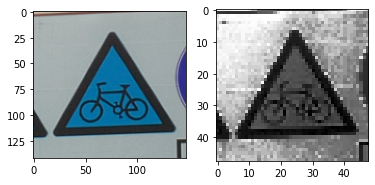

In [4]:
X_processed=[]
for x in X:
    # Write code to resize image x to 48x48 and store in temp_x
    temp_x = cv2.resize(x, (48, 48))
    # Write code to convert temp_x to grayscale
    temp_x = cv2.cvtColor(temp_x, cv2.COLOR_BGR2GRAY)
    # equalize histogram
    temp_x = cv2.equalizeHist(temp_x)
    # Append the converted image into X_processed
    X_processed.append(temp_x)
    
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(X[1])
fig.add_subplot(1, 2, 2)
plt.imshow(X_processed[1],cmap='gray')

### 3.Calculating Features

In [5]:
X_features = []
for x in X_processed:
    x_feature = ft.hog(x, orientations=8, pixels_per_cell=(10, 10),cells_per_block=(1, 1), visualize=False, multichannel=False)
    X_features.append(x_feature)

### 4.Training and testing the classifier

In [6]:
# # repeat experiment several times
# for i in range (0,10):
#     X_train=[]
#     X_test=[]
#     y_train=[]
#     y_test=[]
    
#     # write code to Split training & testing sets using sklearn.model_selection.train_test_split
#     X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size = 0.2)
    
#     #SVM
#     accuracy_SVM=[]
#     clf = svm.SVC()
#     clf.fit(X_train, y_train)
#     accuracy_SVM.append(clf.score(X_test, y_test))
    
#     #RandomForest classifier
#     accuracy_rfclf=[]
#     rfclf = RandomForestClassifier()
#     rfclf.fit(X_train, y_train)
#     accuracy_rfclf.append(rfclf.score(X_test, y_test))
    
#     #Gaussian Naive Bayes
#     accuracy_gnbclf=[]
#     gnbclf = GaussianNB()
#     gnbclf.fit(X_train, y_train)
#     accuracy_gnbclf.append(gnbclf.score(X_test, y_test))
    
#     #k-Nearest Neighbours classifier (k=1)
#     accuracy_kneighclf=[]
#     kneighclf = KNeighborsClassifier(n_neighbors=1)
#     kneighclf.fit(X_train, y_train)
#     accuracy_kneighclf.append(kneighclf.score(X_test, y_test))

# print('SVM:',np.mean(accuracy_SVM))
# print('RandomForest:',np.mean(accuracy_rfclf))
# print('Gaussian Naive Bayes:',np.mean(accuracy_gnbclf))
# print('k-Nearest Neighbours:',np.mean(accuracy_kneighclf))

### 5. K_fold validation

In [7]:
def k_fold_validation(X, y, k, clf_type):
    # split the dataset
    split_len = int(len(X) / k) + 1
    splitted_X = []
    splitted_y = []
    score = 0
    for i in range(k):
        splitted_X.append(X[i*split_len:(i+1)*split_len])
        splitted_y.append(y[i*split_len:(i+1)*split_len])
    for i in range(k):
        X_test = splitted_X[i]
        y_test = splitted_y[i]
        X_train = []
        y_train = []
        for j in range(k):
            if j == i:
                continue
            for item in splitted_X[j]:
                X_train.append(item)
            for item in splitted_y[j]:
                y_train.append(item)
        # Create classifier for the method
        knn = False
        if clf_type == 'SVM':
            clf = svm.SVC()
        elif clf_type == 'RandomForest':
            clf = RandomForestClassifier()
        elif clf_type == 'Gaussian':
            clf = GaussianNB()
        else:
            knn = True
        # Train and test using the method
        if not knn:
            clf.fit(X_train, y_train)
            score += clf.score(X_test, y_test)
        else:
            result = []
            for i in range(1, 6):
                kneighclf = KNeighborsClassifier(n_neighbors=2*i-1)
                kneighclf.fit(X_train, y_train)
                result.append(kneighclf.score(X_test, y_test))
            score += max(result)
    return score / k

In [12]:
name = ['SVM','RandomForest','Gaussian','k-Nearest']
accu = []
for method in name:
    accu.append(k_fold_validation(X_features, y, 5, method))
    print(method, 'done!')
plt.bar(name, accu, color="#87CEFA")
plt.xlabel('classifier')
plt.ylabel("accuracy")
plt.title("The accuracy of different calssifier")
for a, b in zip(name, accu):
    plt.text(a, b, '%.6f' % b, ha='center', va='bottom', fontsize=11)
plt.show()

5609 5609
5609 5609
